In [9]:
#----------------------------------------------------------------------
# This program reads samples of a Pentek Cobalt 16-bit ADC. 
# Each sample is stored as a 16bit signed integer.
# The data is arranged as '[Inphase Sample ; Quadrature Sample ; Inphase ...]
# The quadrature channel is created digitally by applying a Hilbert transform
# to the Inphase signal - i.e it provides a digital 90deg/(pi/2) phase shift.
#----------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, misc
import allantools
from allantools import noise


#Read dataset and reference
data = np.fromfile('2017_6_20_17_7_40_adc1data.dat',dtype=np.int16,count = 10000000) #Read binary file into an array
ref_data = np.fromfile('2017_6_20_17_7_40_adc1data.dat',dtype=np.int16,count = 2300) #Read binary file into an array

range_sample_extent = 4096    #Number of range bins from radar parameters
blank_range  = 1300          #Range bins blanked for dynamic range

#Ensure the read dataset size is an integer multiple of the no. range bins
if np.size(data)%range_sample_extent != 0:
        a = np.size(data) - np.size(data)%range_sample_extent
        data = data[:a]

print(np.size(data)) #Display number of I & Q samples in dataset 

9998336


In [10]:
#Form complex vectors for data and reference 

Z = data[0::2] + 1j * data[1::2]
del data
ref_complex = ref_data[0::2] + 1j * ref_data[1::2]
del ref_data

num_pulses = np.int(np.size(Z)/range_sample_extent)
print(num_pulses)           #Calculate number of pulses in dataset

n = np.arange(0,np.size(Z)) #Number of samples per channel

print(Z[4096])

1220
(-3162+9107j)


<IPython.core.display.Javascript object>


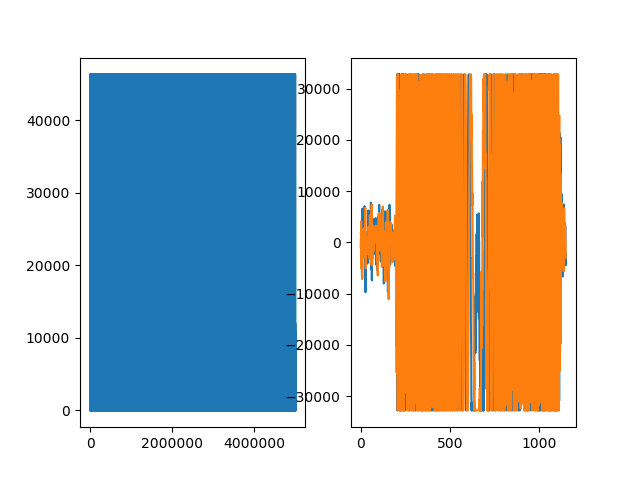

In [3]:
# Display a plot of the in-phase and quadrature channels 
# of the data and reference
%matplotlib notebook 
plt.figure()

# Data
plt.subplot(121)
plt.plot(np.abs(Z))

# Reference 
plt.subplot(122)
plt.plot(np.real(ref_complex))
plt.plot(np.imag(ref_complex))
plt.show()

<IPython.core.display.Javascript object>


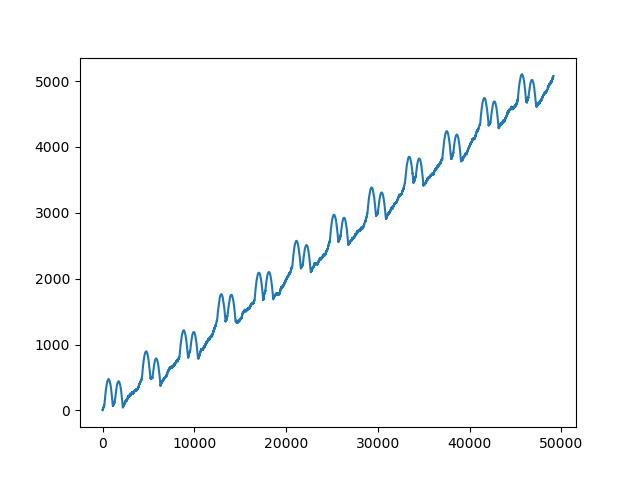

In [20]:
phase_array = np.angle(Z)              #Phase of recording 
phase_unwrap = np.unwrap(phase_array)  #Unwraped phase array

%matplotlib notebook 
plt.figure()
plt.plot(phase_unwrap)                 #Plot phase history of data
plt.show()


In [21]:
sample_matrix = np.zeros((range_sample_extent,num_pulses),dtype = np.complex) #Initialise empty matrix
print(np.shape(sample_matrix)) #sanity check for size of matrix = rows(numofrangebins) x columns(pulsenumber)

# Format the data into a matrix of complex values
# |       pulse1    pulse2  ...   pulseN |
# |--------------------------------------|
# |row1|  sample11   sample12            |
# |row2|  sample21                       |
# |---------------------------------------

row, column = 0, 0 # Initialised loop variables
j = np.size(Z)        # Number of samples in complex data array
for i in range(j):
    
    if row >= blank_range:
        if (row < range_sample_extent):
            sample_matrix[row,column] = Z[i]
        
        else:
            if column<num_pulses-1:
                column += 1
                row = 0
                sample_matrix[row,column] = Z[i]
    
    row += 1  

del Z

print(sample_matrix[0,:])

(4096, 12)
[    0.   +0.j -3162.+9107.j -2257.-7973.j  2777.+4211.j -4421.-2034.j
 -1820.+4156.j  1334. +988.j  -448.+2703.j  -586. +614.j    85.-3820.j
 -3538. +981.j -2374.+2172.j]


In [7]:
# Cross Correlate each range bin with a padded reference function for
# matched filtering.

#NOTES-----------------------------------------------------------------
# At the time of writing, Numpy has no normalised correlation function. 
# One is planned for release, below is an explicit means of normalising.
# Using the 2D correlation function was also too slow, thus a for loop
# interating through each pulse was used instead.
#----------------------------------------------------------------------

pad_width = np.int((range_sample_extent - np.size(ref_complex))/2) #Pad reference for xcorr
padded_ref = np.pad(np.real(ref_complex),pad_width,'constant', constant_values=(0))
padded_ref = (padded_ref - np.mean(padded_ref)) / (np.std(padded_ref) * len(padded_ref))

#Initialise a normalised correlation matrix
norm_corr_matrix = np.ones((range_sample_extent,num_pulses),dtype = np.complex) 

for b in range(num_pulses):
    sample_matrix[:,b] = (sample_matrix[:,b] - np.mean(sample_matrix[:,b]))/(np.std(sample_matrix[:,b]))
    norm_corr_matrix[:,b] = np.correlate((sample_matrix[:,b]),padded_ref,'same')


<IPython.core.display.Javascript object>


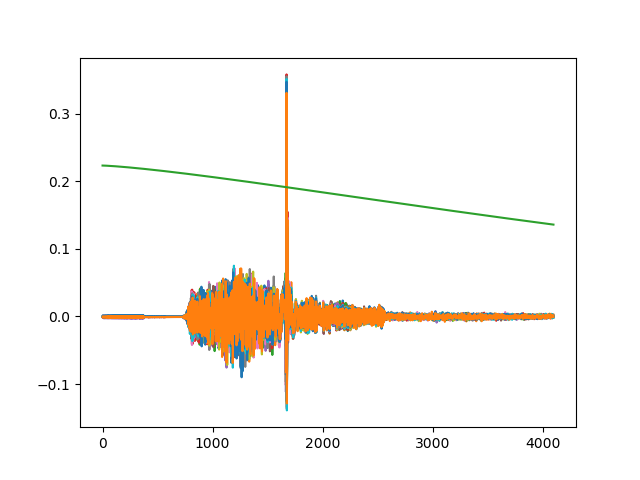

In [8]:
n = np.arange(0,np.size(padded_ref))
# This shaping function is used if one wants to threshold the correlated data.
x = -1.5-0.00001*n**1.3
shape_threshold = np.zeros(range_sample_extent)
shape_threshold = np.exp(x)

plt.figure()
plt.plot(np.real(norm_corr_matrix[:,:]))
plt.plot(n,shape_threshold) #Plot correlation
plt.show()


<IPython.core.display.Javascript object>


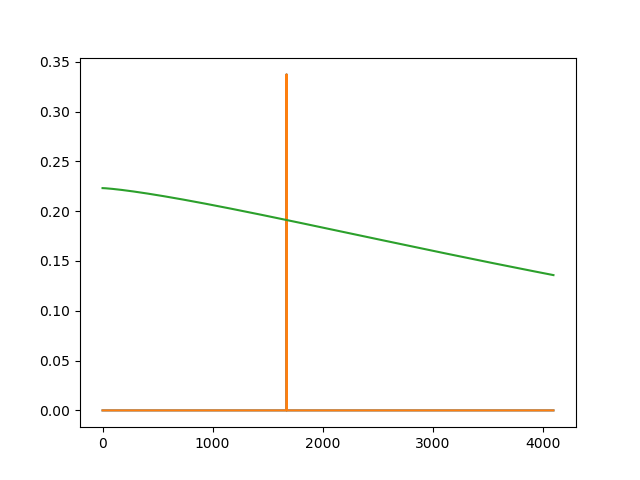

In [9]:
# Removing data below threshold

shape_corr_matrix = np.zeros((range_sample_extent,num_pulses),dtype = np.complex)
for i in range(range_sample_extent):
    for k in range(num_pulses):
        if norm_corr_matrix[i,k] < shape_threshold[i]:
            shape_corr_matrix[i,k] = 0
        else:
            shape_corr_matrix[i,k] = norm_corr_matrix[i,k]

plt.figure()
plt.plot(n,np.real(shape_corr_matrix[:,1]),n,np.real(shape_corr_matrix[:,1]))
plt.plot(shape_threshold) #Plot correlation
plt.show()            


<IPython.core.display.Javascript object>


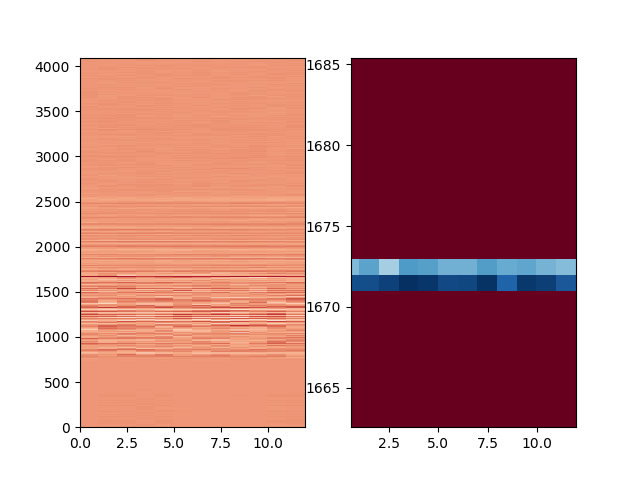

In [10]:
# RTI plots of range matrix with and without threshold

plt.figure()

#Normalised range vs time
plt.subplot(121)
plt.pcolormesh(np.real(norm_corr_matrix),cmap='RdBu')

#Threshold applied 
plt.subplot(122)
plt.pcolormesh(np.real(shape_corr_matrix),cmap='RdBu')
plt.show()



In [14]:
static_range_array = np.zeros(num_pulses,dtype=np.complex)

for i in range(num_pulses):
    static_range_array[i] = sample_matrix[0,i]
            
print (static_range_array)

[ 0.00624272 -4.23735251e-03j -2.27133654 +6.58773247e+00j
 -1.57902302 -5.65507240e+00j  2.00578331 +2.98492517e+00j
 -3.15699440 -1.47374761e+00j -1.35492264 +3.09097064e+00j
  0.96390099 +6.95294003e-01j -0.32380289 +1.98395396e+00j
 -0.40364767 +4.33405461e-01j  0.07888530 -2.94086329e+00j
 -2.62244004 +7.29279605e-01j -1.73237215 +1.59712235e+00j]


<IPython.core.display.Javascript object>


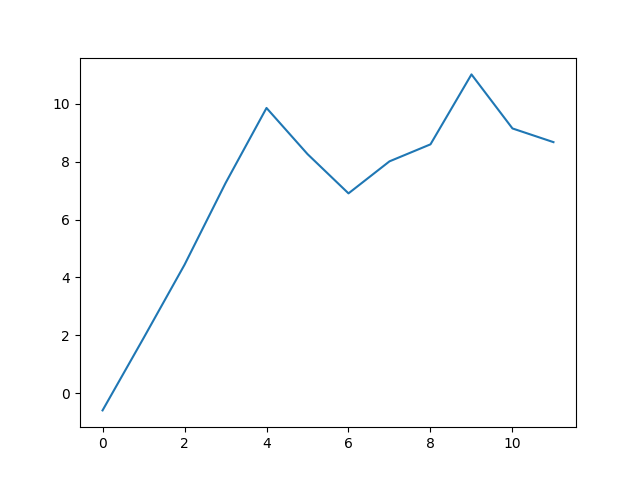

In [15]:
a  =np.arange(num_pulses)
plt.figure()
phase_data = np.unwrap(np.angle(static_range_array))
plt.plot(a, phase_data)

plt.show()


In [53]:
rate = 1000 # data rate in Hz
taus = [0.01,0.1,1,2,3,4,5] #  tau-values in seconds

# phase data
(taus_used, adev, adeverror, adev_n) = allantools.oadev(phase_data, rate=rate, taus=taus)

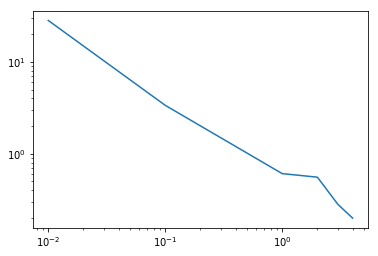

In [54]:
plt.figure()
plt.loglog(taus_used,adev)
plt.show()